Visualising the location of all clusters in the dataset

'../data/finalised_cutouts/cluster_cutouts'

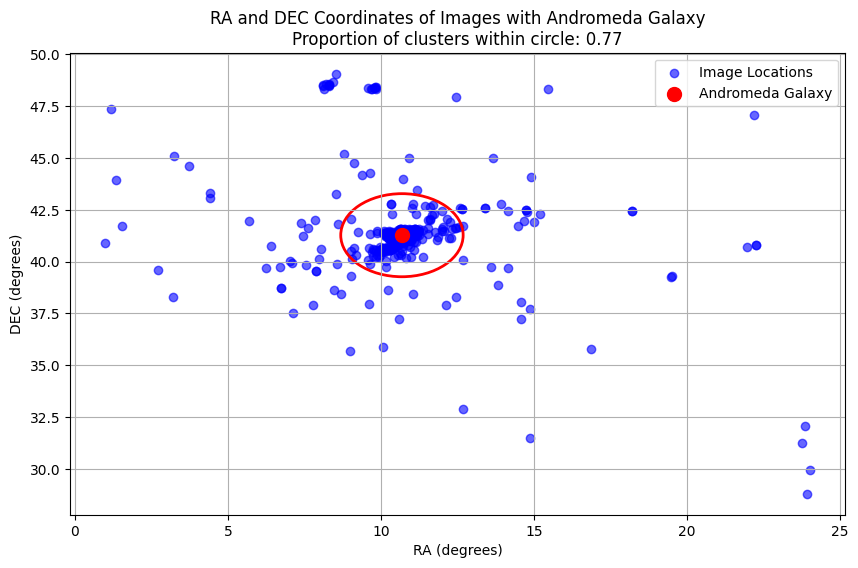

Total clusters: 473
Clusters within circle: 364
Proportion of clusters within circle: 0.77


In [26]:
import os
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Directory containing the images
image_directory = '../data/real_cutouts_cleaned/cluster'

# Lists to store RA and DEC values
ra_list = []
dec_list = []

# Function to extract RA and DEC from filename
def extract_ra_dec(filename):
    match = re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename)
    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        return ra, dec
    return None, None

# Iterate over each file in the image directory
for root, dirs, files in os.walk(image_directory):
    for filename in files:
        if filename.lower().endswith('.png'):
            ra, dec = extract_ra_dec(filename)
            if ra is not None and dec is not None and 0 <= ra <= 50:
                ra_list.append(ra)
                dec_list.append(dec)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ra_list, dec_list, color='blue', alpha=0.6, label='Image Locations')

# Add a red dot for the Andromeda Galaxy
andromeda_ra = 10.6847083
andromeda_dec = 41.26875
plt.scatter(andromeda_ra, andromeda_dec, color='red', s=100, label='Andromeda Galaxy')

# Add a circle around the Andromeda Galaxy
circle_radius = 2  # Adjust the radius as needed
circle = Circle((andromeda_ra, andromeda_dec), radius=circle_radius, edgecolor='red', facecolor='none', linewidth=2)
plt.gca().add_patch(circle)

# Calculate the proportion of clusters within the circle
clusters_within_circle = 0
total_clusters = len(ra_list)

for ra, dec in zip(ra_list, dec_list):
    if ((ra - andromeda_ra)**2 + (dec - andromeda_dec)**2) <= circle_radius**2:
        clusters_within_circle += 1

proportion_within_circle = clusters_within_circle / total_clusters

# Add labels and title
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.title(f'RA and DEC Coordinates of Images with Andromeda Galaxy\nProportion of clusters within circle: {proportion_within_circle:.2f}')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

print(f"Total clusters: {total_clusters}")
print(f"Clusters within circle: {clusters_within_circle}")
print(f"Proportion of clusters within circle: {proportion_within_circle:.2f}")

In [28]:
import os
import re
import shutil
from matplotlib.patches import Circle

# Directory containing the images
image_directory = '../data/real_cutouts_cleaned/cluster'
within_circle_directory = '../data/real_cutouts_cleaned/within_circle'
outside_circle_directory = '../data/real_cutouts_cleaned/outside_circle'

# Create output directories if they don't exist
os.makedirs(within_circle_directory, exist_ok=True)
os.makedirs(outside_circle_directory, exist_ok=True)

# Andromeda Galaxy coordinates
andromeda_ra = 10.6847083
andromeda_dec = 41.26875
circle_radius = 2

# Function to extract RA and DEC from filename
def extract_ra_dec(filename):
    match = re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename)
    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        return ra, dec
    return None, None

# Iterate over each file in the image directory
for root, dirs, files in os.walk(image_directory):
    for filename in files:
        if filename.lower().endswith('.png'):
            ra, dec = extract_ra_dec(filename)
            if ra is not None and dec is not None and 0 <= ra <= 50:
                # Check if the cluster is within the circle
                if ((ra - andromeda_ra)**2 + (dec - andromeda_dec)**2) <= circle_radius**2:
                    target_dir = within_circle_directory
                else:
                    target_dir = outside_circle_directory
                
                # Copy the image to the target directory
                shutil.copy(os.path.join(root, filename), os.path.join(target_dir, filename))

print("Clusters have been separated into the respective folders.")

Clusters have been separated into the respective folders.


Visualise the cummulative Yilun Wang objects, compared to their pgc

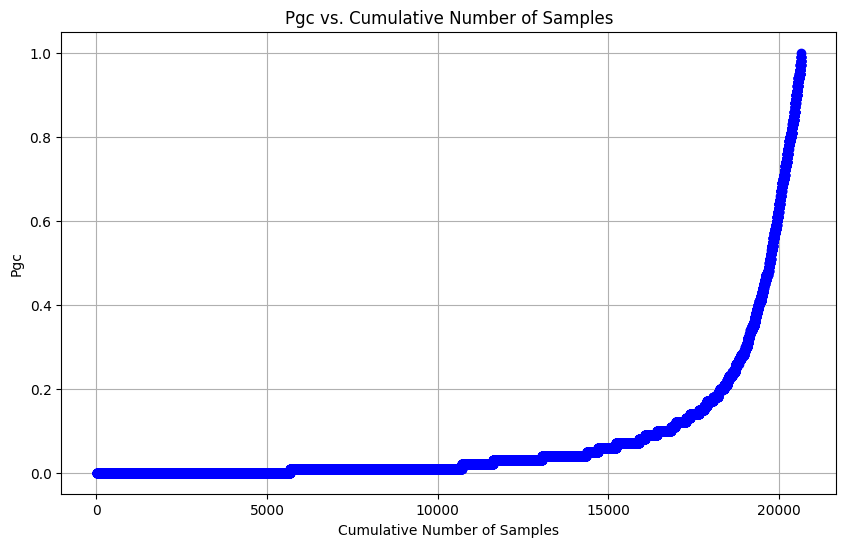

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
input_file = '../Finding Real Images/All_Yilun_Wang_data_for_Oscar.csv'
df = pd.read_csv(input_file)

# Sort the DataFrame by Pgc
df_sorted = df.sort_values(by='Pgc')

# Calculate the cumulative number of samples
df_sorted['Cumulative'] = range(1, len(df_sorted) + 1)

# Plot Pgc against the cumulative number of samples
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['Cumulative'], df_sorted['Pgc'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Cumulative Number of Samples')
plt.ylabel('Pgc')
plt.title('Pgc vs. Cumulative Number of Samples')
plt.grid(True)

# Show the plot
plt.show()

Removes duplicates or synthetics from folder

In [ ]:
import os
import re

# Directory containing the images
image_directory = '../data/your_image_directory'  # Replace with your image directory

# Function to check if filename contains RA and DEC
def has_ra_dec(filename):
    return re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename) is not None

# Function to get the base part of the filename (before RA and DEC)
def get_base_filename(filename):
    match = re.match(r'^(cutout_m\d+_g_ccd_\d+)', filename)
    if match:
        return match.group(1)
    return None

# Set to store unique base filenames
unique_bases = set()

# Iterate over each file in the image directory
for filename in os.listdir(image_directory):
    file_path = os.path.join(image_directory, filename)

    # Check if the file is an image
    if filename.lower().endswith('.png'):
        # Check if the filename contains RA and DEC
        if not has_ra_dec(filename):
            os.remove(file_path)
            print(f"Removed: {filename} (no RA/DEC)")
            continue

        # Get the base part of the filename
        base_filename = get_base_filename(filename)
        if base_filename:
            if base_filename in unique_bases:
                os.remove(file_path)
                print(f"Removed: {filename} (duplicate)")
            else:
                unique_bases.add(base_filename)

print("Cleanup complete.")

On a scale plot distance to andromeda galaxy vs proportion of wrong and right

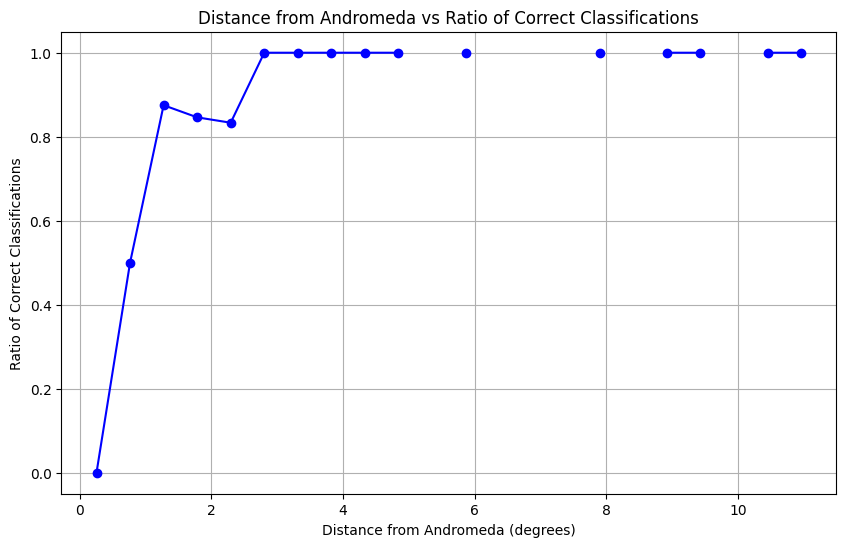

In [13]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Andromeda Galaxy coordinates
andromeda_ra = 10.6847083
andromeda_dec = 41.26875

# Directories containing the classified images
correct_dir = '../data/correct_incorrect_G_128SRNC/correct'
incorrect_dir = '../data/correct_incorrect_G_128SRNC/incorrect'

# Function to extract RA and DEC from filename
def extract_ra_dec(filename):
    match = re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename)
    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        return ra, dec
    return None, None

# Function to calculate distance from Andromeda
def calculate_distance(ra, dec):
    return np.sqrt((ra - andromeda_ra)**2 + (dec - andromeda_dec)**2)

# Lists to store distances and labels
distances = []
labels = []

# Process correct images
for filename in os.listdir(correct_dir):
    if filename.lower().endswith('.png'):
        ra, dec = extract_ra_dec(filename)
        if ra is not None and dec is not None:
            distance = calculate_distance(ra, dec)
            distances.append(distance)
            labels.append(1)  # Correct

# Process incorrect images
for filename in os.listdir(incorrect_dir):
    if filename.lower().endswith('.png'):
        ra, dec = extract_ra_dec(filename)
        if ra is not None and dec is not None:
            distance = calculate_distance(ra, dec)
            distances.append(distance)
            labels.append(0)  # Incorrect

# Convert to numpy arrays
distances = np.array(distances)
labels = np.array(labels)

# Increase the number of bins
num_bins = 35
bins = np.linspace(0, max(distances), num_bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
correct_ratios = []

for i in range(len(bins) - 1):
    bin_mask = (distances >= bins[i]) & (distances < bins[i + 1])
    bin_labels = labels[bin_mask]
    if len(bin_labels) > 0:
        correct_ratio = np.sum(bin_labels) / len(bin_labels)
        correct_ratios.append(correct_ratio)
    else:
        correct_ratios.append(np.nan)

# Plot the distance from Andromeda vs the ratio of correct classifications
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, correct_ratios, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Distance from Andromeda (degrees)')
plt.ylabel('Ratio of Correct Classifications')
plt.title('Distance from Andromeda vs Ratio of Correct Classifications')
plt.grid(True)

# Show the plot
plt.show()

Plot points individually

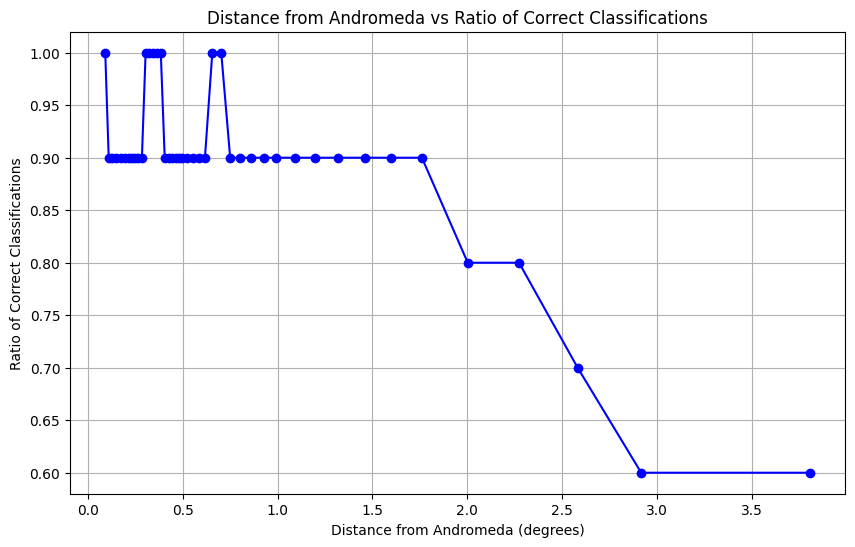

In [9]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# Andromeda Galaxy coordinates
andromeda_ra = 10.6847083
andromeda_dec = 41.26875

# Directories containing the classified images
correct_dir = '../data/correct_incorrect_128SRNC/correct'
incorrect_dir = '../data/correct_incorrect_128SRNC/incorrect'

# Function to extract RA and DEC from filename
def extract_ra_dec(filename):
    match = re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename)
    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        return ra, dec
    return None, None

# Function to calculate distance from Andromeda
def calculate_distance(ra, dec):
    return np.sqrt((ra - andromeda_ra)**2 + (dec - andromeda_dec)**2)

# Lists to store distances and labels
distances = []
labels = []

# Process correct images
for filename in os.listdir(correct_dir):
    if filename.lower().endswith('.png'):
        ra, dec = extract_ra_dec(filename)
        if ra is not None and dec is not None:
            distance = calculate_distance(ra, dec)
            distances.append(distance)
            labels.append(1)  # Correct

# Process incorrect images
for filename in os.listdir(incorrect_dir):
    if filename.lower().endswith('.png'):
        ra, dec = extract_ra_dec(filename)
        if ra is not None and dec is not None:
            distance = calculate_distance(ra, dec)
            distances.append(distance)
            labels.append(0)  # Incorrect

# Convert to numpy arrays
distances = np.array(distances)
labels = np.array(labels)

# Sort distances and labels by distance
sorted_indices = np.argsort(distances)
distances = distances[sorted_indices]
labels = labels[sorted_indices]

# Calculate the ratio of correct classifications using a sliding window
window_size = 10  # Adjust the window size as needed
correct_ratios = []
window_centers = []

for i in range(len(distances) - window_size + 1):
    window_distances = distances[i:i + window_size]
    window_labels = labels[i:i + window_size]
    correct_ratio = np.sum(window_labels) / window_size
    correct_ratios.append(correct_ratio)
    window_centers.append(np.mean(window_distances))

# Plot the distance from Andromeda vs the ratio of correct classifications
plt.figure(figsize=(10, 6))
plt.plot(window_centers, correct_ratios, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Distance from Andromeda (degrees)')
plt.ylabel('Ratio of Correct Classifications')
plt.title('Distance from Andromeda vs Ratio of Correct Classifications')
plt.grid(True)

# Show the plot
plt.show()

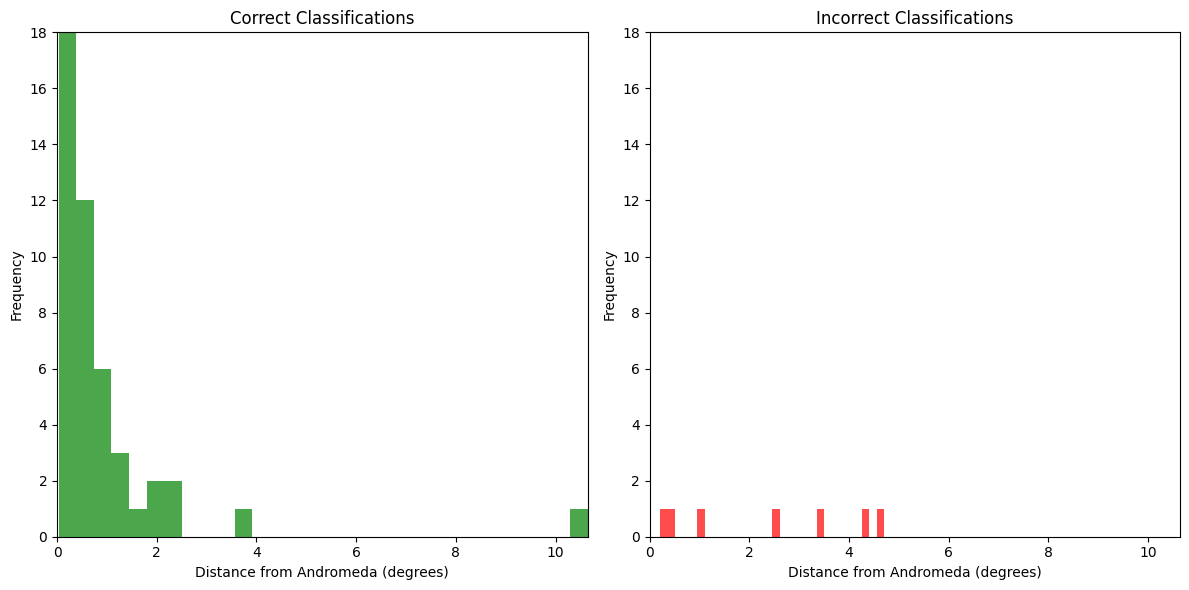

In [16]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# Andromeda Galaxy coordinates
andromeda_ra = 10.6847083
andromeda_dec = 41.26875

# Directories containing the classified images
correct_dir = '../data/correct_incorrect_128SRNC/correct'
incorrect_dir = '../data/correct_incorrect_128SRNC/incorrect'

# Function to extract RA and DEC from filename
def extract_ra_dec(filename):
    match = re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename)
    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        return ra, dec
    return None, None

# Function to calculate distance from Andromeda
def calculate_distance(ra, dec):
    return np.sqrt((ra - andromeda_ra)**2 + (dec - andromeda_dec)**2)

# Lists to store distances for correct and incorrect classifications
correct_distances = []
incorrect_distances = []

# Process correct images
for filename in os.listdir(correct_dir):
    if filename.lower().endswith('.png'):
        ra, dec = extract_ra_dec(filename)
        if ra is not None and dec is not None:
            distance = calculate_distance(ra, dec)
            correct_distances.append(distance)

# Process incorrect images
for filename in os.listdir(incorrect_dir):
    if filename.lower().endswith('.png'):
        ra, dec = extract_ra_dec(filename)
        if ra is not None and dec is not None:
            distance = calculate_distance(ra, dec)
            incorrect_distances.append(distance)

# Convert to numpy arrays
correct_distances = np.array(correct_distances)
incorrect_distances = np.array(incorrect_distances)

# Determine the range for the x-axis and y-axis
x_range = (0, max(np.max(correct_distances), np.max(incorrect_distances)))
y_max = max(np.histogram(correct_distances, bins=30)[0].max(), np.histogram(incorrect_distances, bins=30)[0].max())

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for correct classifications
plt.subplot(1, 2, 1)
plt.hist(correct_distances, bins=30, color='green', alpha=0.7)
plt.xlabel('Distance from Andromeda (degrees)')
plt.ylabel('Frequency')
plt.title('Correct Classifications')
plt.xlim(x_range)
plt.ylim(0, y_max)

# Histogram for incorrect classifications
plt.subplot(1, 2, 2)
plt.hist(incorrect_distances, bins=30, color='red', alpha=0.7)
plt.xlabel('Distance from Andromeda (degrees)')
plt.ylabel('Frequency')
plt.title('Incorrect Classifications')
plt.xlim(x_range)
plt.ylim(0, y_max)

# Show the plot
plt.tight_layout()
plt.show()

## Plot GC distance

85.69463548830811 % clusters inside the ellipse


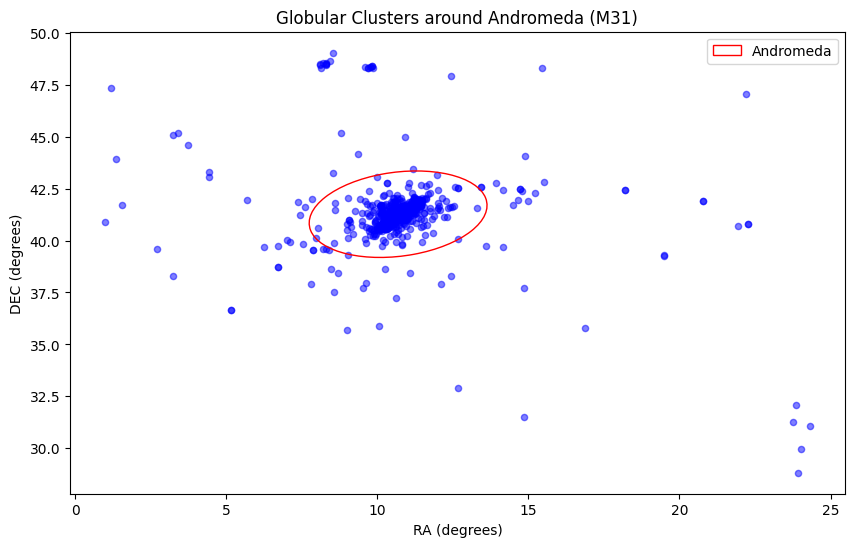

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Load the CSV file
input_file = '../Finding Real Images/result_GC.csv'
df = pd.read_csv(input_file)

# Andromeda Galaxy coordinates
andromeda_ra = 10.6847083
andromeda_dec = 41.26875

# Extract RA and DEC from the DataFrame
ra_list = df['RADEG']
dec_list = df['DECDEG']

# Filter out RA values over 50
filtered_ra = ra_list[ra_list <= 50]
filtered_dec = dec_list[ra_list <= 50]

# Ellipse parameters
ellipse_width = 6
ellipse_height = 4
ellipse_angle = 15

# Function to check if a point is inside the ellipse
def is_inside_ellipse(x, y, ellipse_center, width, height, angle):
    angle_rad = np.deg2rad(angle)
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)
    xc = x - ellipse_center[0]
    yc = y - ellipse_center[1]
    x_rot = xc * cos_angle + yc * sin_angle
    y_rot = -xc * sin_angle + yc * cos_angle
    return (x_rot**2 / (width / 2)**2 + y_rot**2 / (height / 2)**2) <= 1

# Calculate the number of points inside the ellipse
inside_ellipse = [is_inside_ellipse(x, y, (andromeda_ra, andromeda_dec), ellipse_width, ellipse_height, ellipse_angle) for x, y in zip(filtered_ra, filtered_dec)]
percentage_inside = np.sum(inside_ellipse) / len(inside_ellipse) * 100

print(percentage_inside, "% clusters inside the ellipse")


# Plot the RA and DEC as a scatter plot with smaller points
plt.figure(figsize=(10, 6))
plt.scatter(filtered_ra, filtered_dec, c='blue', alpha=0.5, s=20)  # Adjust the 's' parameter for smaller points
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.title(f'Globular Clusters around M31')
# plt.grid(True)

# Draw an oval representing Andromeda at a 45-degree angle
ellipse = Ellipse((andromeda_ra, andromeda_dec), width=ellipse_width, height=ellipse_height, angle=ellipse_angle, edgecolor='red', facecolor='none', linewidth=1, label='Andromeda')
plt.gca().add_patch(ellipse)

plt.legend()
plt.show()